<a href="https://www.kaggle.com/code/mariuszcha/price-prediction-nn-fast-ai-random-forest?scriptVersionId=131636441" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**I opted to tackle the task of predicting house prices using both random forests and neural networks. With random forests, I was able to easily determine the importance of features in the prediction process - which was useful in NN, because I decided to use found columns**

In [1]:
from fastai.tabular.all import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('flare')

In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv', index_col=0)
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col=0)

# EDA:

In step below - I did quite simple EDA - finding the most influential features according to Pearson coef matrix and barplots(for categorical columns). The point of that project is to practice random forests and neural network so i'm not going to perform deep EDA.

/tmp/ipykernel_20/1993873652.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  num = train_df.corr().SalePrice.abs().sort_values(ascending=False).head(21)[1:].index
/tmp/ipykernel_20/1993873652.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(train_df.corr().SalePrice.abs().sort_values(ascending=False).head(21)[1:])


OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
Name: SalePrice, dtype: float64


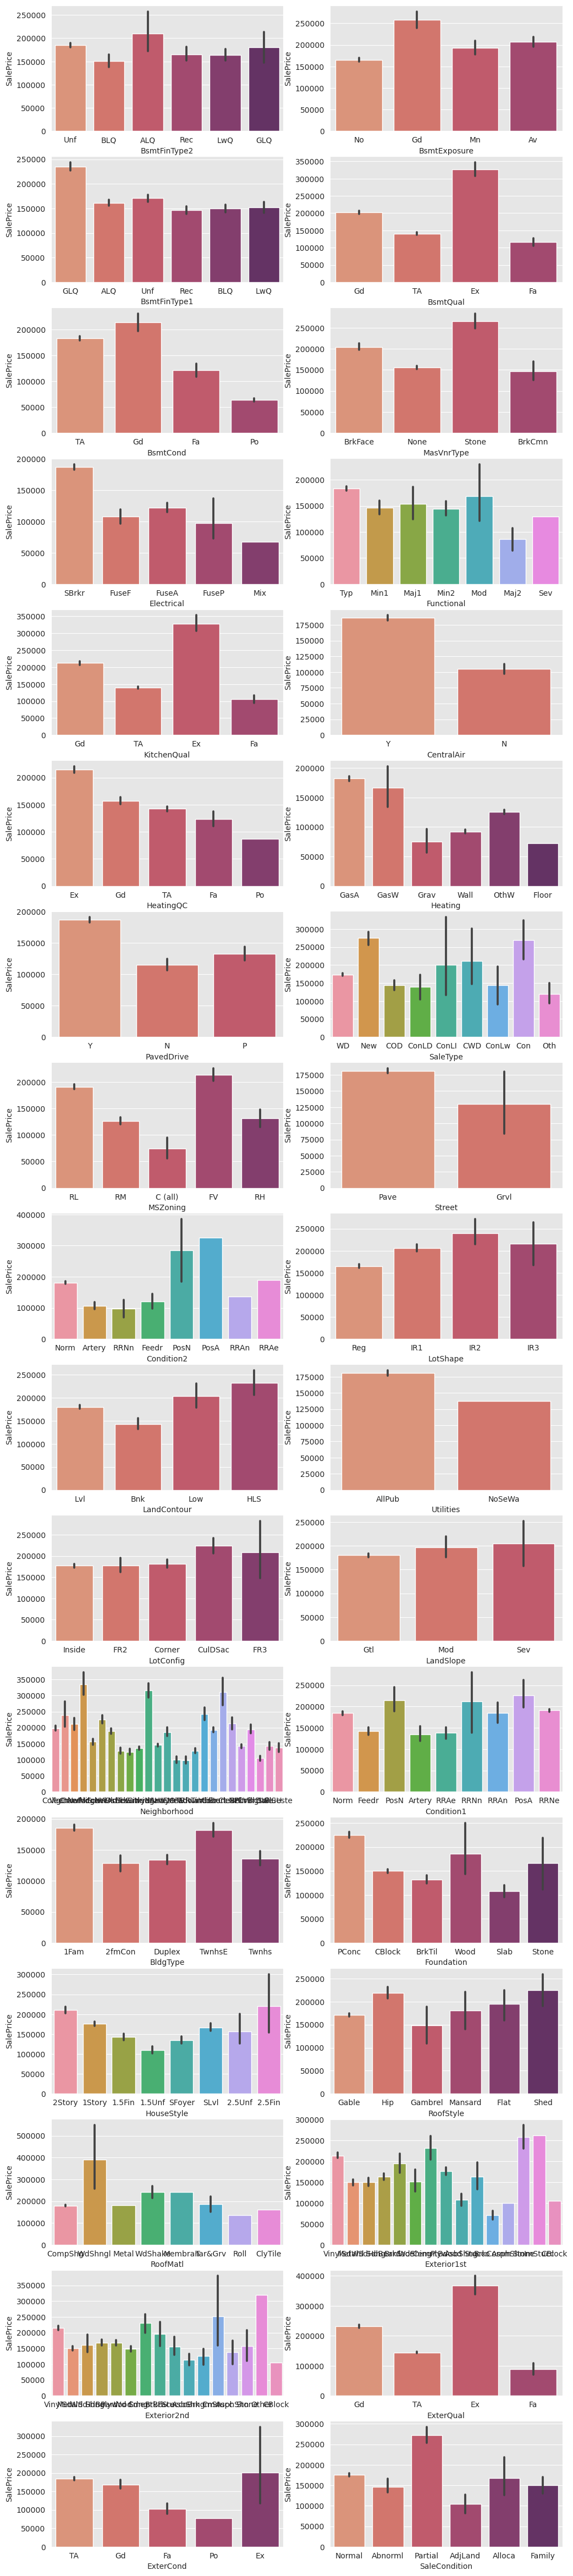

In [3]:
# List of categorical cols according to plots:
cat = train_df.select_dtypes(exclude=['int','float']).isna().sum().sort_values(ascending=False).tail(34).index
# List of continuous cols according to Pearson coef:
num = train_df.corr().SalePrice.abs().sort_values(ascending=False).head(21)[1:].index
tar = 'SalePrice'

print(train_df.corr().SalePrice.abs().sort_values(ascending=False).head(21)[1:])

# Categorical cols:
fig, axes = plt.subplots(17,2, figsize=(12,60))
axes = axes.flatten()
for i,j in enumerate(cat):
    sns.barplot(x=train_df[j], y=train_df[tar], ax = axes[i])

In [4]:
# Columns selected to modeling and predicting:
finalColumns = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','ExterQual','FullBath','YearBuilt'
               ,'BsmtQual','KitchenQual','Fireplaces','HeatingQC','CentralAir']

cat = ['OverallQual','ExterQual','BsmtQual','KitchenQual','HeatingQC','CentralAir']
num = ['GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','Fireplaces','YearBuilt']

# Random Forest:

Now we are going to check how Random Forests will perform using selected columns. Firstly we will fill missing values(for categorial we will use mode, and for continuous 0 value). We will also transform target value and continouos features using Log Transform.

In [5]:
# Filling missing values..
def preprocessing(df):
    df[cat] = df[cat].fillna(df[cat].mode().iloc[0])  
    df[num] = df[num].fillna(0)
    return df

# Encoding categorical features to numerical one...
def encoder(df):
    mapper = { 'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4 }
    df = df.replace(mapper)
    df['CentralAir'] = df['CentralAir'].replace({'Y':1,'N':0})
    return df

<Axes: xlabel='SalePrice', ylabel='Count'>

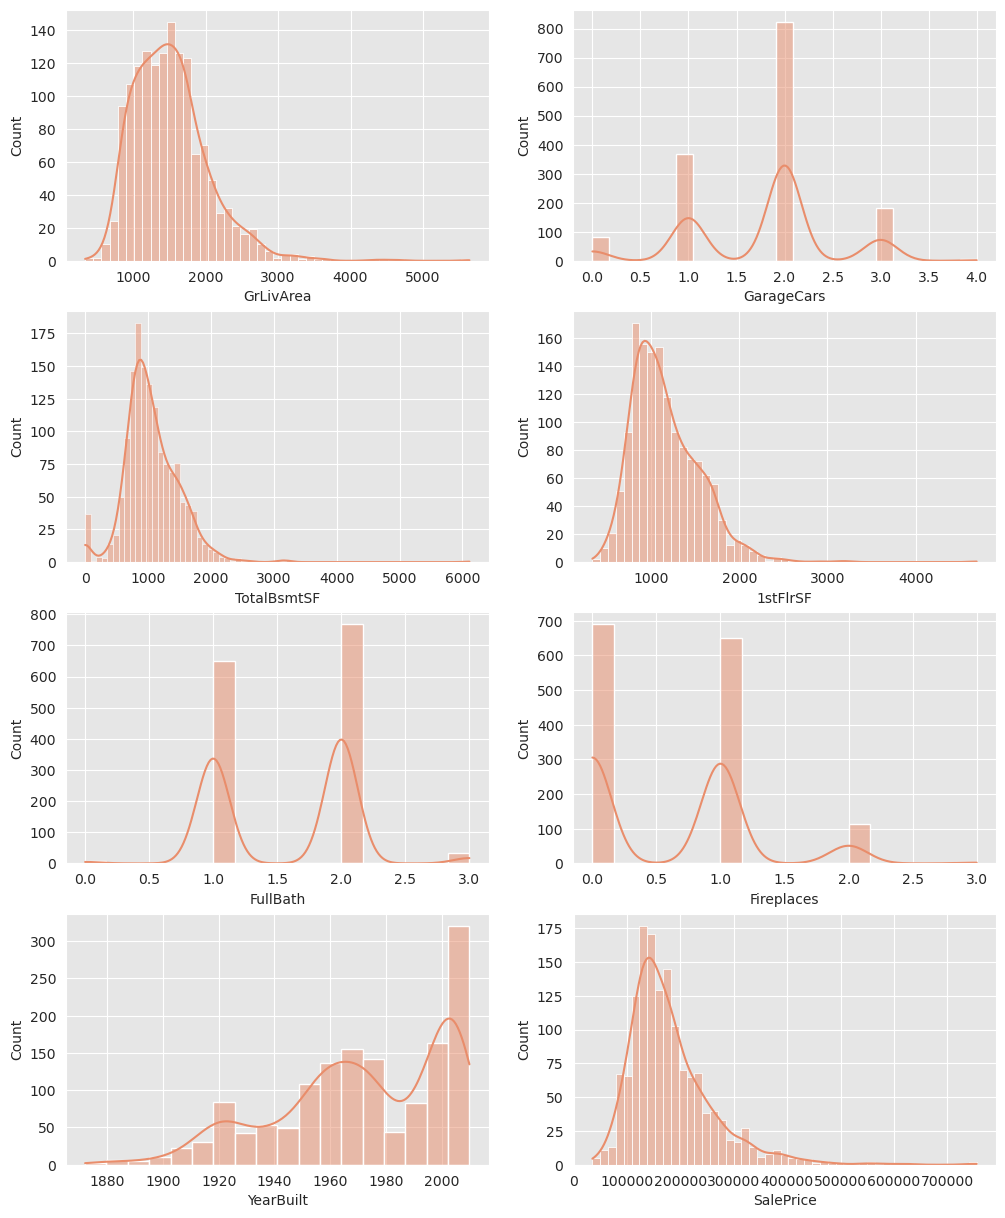

In [6]:
train_df_RF = encoder(preprocessing(train_df[finalColumns].copy()))
test_df_RF = encoder(preprocessing(train_df[finalColumns].copy()))
target_RF = train_df[tar].copy()

fig, axes = plt.subplots(4,2, figsize=(12,15))
axes = axes.flatten()
for i,j in enumerate(num):
    sns.histplot(x=train_df_RF[j], ax = axes[i], kde=True)
sns.histplot(x=target_RF, ax = axes[7], kde=True)

As we can see at plots above. Data is skewed. SalePrice is right skewed. GrLivArea, TotalBsmtSF, 1stFlrSF, YearBuilt too. We are going to log transform them. I forgot to mention that earlier - but TotalBsmtSF, GrLivArea and 1stFlrSF have definitely some correlation between each other. Probably rejecting one of them could keep our model to perform well.
We call that thing collinearity, when two features are explaining quite similar thing in data. For now - we will keep all three. We will later examine our feature importances in Random Forest and reject some of them.

In [7]:
for i in ['GrLivArea','TotalBsmtSF','1stFlrSF','YearBuilt']:
    train_df_RF[i] = np.log1p(train_df_RF[i])
    test_df_RF[i] = np.log1p(test_df_RF[i])
    
target_RF = np.log1p(target_RF)

In [8]:
# Splitting our data and training simple Baseline model...
X_train, X_valid, y_train, y_valid = train_test_split(train_df_RF, target_RF, random_state=91, test_size=0.2)

model = RandomForestRegressor(max_features='sqrt', n_estimators=200)
model.fit(X_train, y_train)

print('Train rmse: ',mean_squared_error(model.predict(X_train), y_train, squared=False))
print('Validation rmse: ',mean_squared_error(model.predict(X_valid), y_valid, squared=False))
print(pd.DataFrame({'Column':finalColumns,'Importance':model.feature_importances_}))

Train rmse:  0.05740196696480367
Validation rmse:  0.1465215785214043
         Column  Importance
0   OverallQual    0.178007
1     GrLivArea    0.177195
2    GarageCars    0.064588
3   TotalBsmtSF    0.094256
4      1stFlrSF    0.079353
5     ExterQual    0.102666
6      FullBath    0.039306
7     YearBuilt    0.082980
8      BsmtQual    0.060100
9   KitchenQual    0.060211
10   Fireplaces    0.032038
11    HeatingQC    0.011138
12   CentralAir    0.018162


As we can see, validation RMSE is much higher. The reason of that could be - our quite straight-forward approach to coding our features and transforming them. We should also check how both datasets generalize.

In [9]:
predictions = model.predict(test_df_RF[finalColumns])
#pd.DataFrame({'SalePrice':np.expm1(predictions)}, index=test_df_RF.index).to_csv('submission.csv')

Now we will proceed with the same task, but this time utilizing a simple neural network built with FAST AI. Additionally, we will apply normalization, fill missing values, and categorize the data using FAST AI's preprocessing techniques.

# Neural Network:

In [10]:
# Copied from above just for clarity...
finalColumnsNN = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','ExterQual','FullBath','YearBuilt'
               ,'BsmtQual','KitchenQual','Fireplaces','HeatingQC','CentralAir','SalePrice']
cat = ['OverallQual','ExterQual','BsmtQual','KitchenQual','HeatingQC','CentralAir']
num = ['GrLivArea','GarageCars','TotalBsmtSF','1stFlrSF','FullBath','Fireplaces','YearBuilt']
target = ['SalePrice']

# Creating copy of our train data. We also copy test dataframe.
train_df_NN = train_df[finalColumnsNN].copy()
test_df_NN = test_df.copy()

# V here is small problem. There are columns on our test data which contain missing values - when on train data, there aren't
# any. Our FastAI FillMissing transformer has problem with dealing with that thing. We are - just to simplify for now our
# baseline model - going to fill all NaNs with 0
test_df_NN = test_df_NN.fillna(0)

# We will log transform our target to have an opportunity to compare Random Forests RMSE and NN...
train_df_NN['SalePrice'] = np.log1p(train_df_NN['SalePrice'])

# FastAI splitter. Basically it samples indexes from whole population.
splits=RandomSplitter()(range_of(train_df_NN))

# Preprocessing transformers...
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(train_df_NN, procs, cat, num, y_names=target, splits=splits)
dls = to.dataloaders(bs=64)

In [11]:
# We use simple NN with 150 neurons on first hidden layer and 250 in second one. We also use Callback to stop fitting
# when our model is going to overfit...
learn = tabular_learner(dls, layers=[150, 250], metrics = rmse, n_out=1)
learn.fit_one_cycle(30, 0.01, cbs = EarlyStoppingCallback(patience=5))

#learn.lr_find()

epoch,train_loss,valid_loss,_rmse,time
0,143.193619,143.089539,11.962004,00:00
1,140.657761,136.651093,11.689786,00:00
2,130.085098,92.457764,9.615497,00:00
3,96.387741,4.867594,2.206263,00:00
4,62.814919,2.522929,1.588373,00:00
5,41.512802,0.665546,0.815810,00:00
6,27.862120,0.142133,0.377005,00:00
7,18.914473,0.061870,0.248737,00:00
8,12.954440,0.191976,0.438151,00:00
9,8.922101,0.077008,0.277503,00:00


In [12]:
test_data = dls.test_dl(test_df_NN)
preds, _ = learn.get_preds(dl=test_data)

#pd.DataFrame({'SalePrice':np.expm1(preds.flatten())}, index=test_df_NN.index).to_csv('submission.csv')